In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle

In [36]:
import warnings
warnings.filterwarnings("ignore")

## Define helper functions

In [98]:
def split_d1(row, branching, leaves):
    if row[branching[0]] == 0:
        return row[f'y{leaves[0]}']
    else:
        return row[f'y{leaves[1]}']
    
def split_d1_prob(row, branching, leaves):
    if type(branching[0]) == dict:
        return np.sum(branching[0][k] * row[f'y{k}'] for k in range(2))
    else:
        if row[branching[0]] == 0:
            return np.sum(leaves[0][k] * row[f'y{k}'] for k in range(2))
        else:
            return np.sum(leaves[1][k] * row[f'y{k}'] for k in range(2))
    
def split_d2(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return row[f'y{leaves[0]}']
        else:
            return row[f'y{leaves[1]}']
    else:
        if row[branching[2]] == 0:
            return row[f'y{leaves[2]}']
        else:
            return row[f'y{leaves[3]}']

def split_d2_prob_coinflip(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return row[f'y{np.random.choice(np.arange(3), p=list(leaves[0].values()))}']
        else:
            return row[f'y{np.random.choice(np.arange(3), p=list(leaves[1].values()))}']
    else:
        if row[branching[2]] == 0:
            return row[f'y{np.random.choice(np.arange(3), p=list(leaves[2].values()))}']
        else:
            return row[f'y{np.random.choice(np.arange(3), p=list(leaves[3].values()))}']
        
def split_d2_prob(row, branching, leaves):
    if row[branching[0]] == 0:
        if type(branching[1]) == dict:
            return np.sum(branching[1][k] * row[f'y{k}'] for k in range(3))
        else:
            if row[branching[1]] == 0:
                return np.sum(leaves[0][k] * row[f'y{k}'] for k in range(3))
            else:
                return np.sum(leaves[1][k] * row[f'y{k}'] for k in range(3))
    else:
        if type(branching[2]) == dict:
            return np.sum(branching[2][k] * row[f'y{k}'] for k in range(3))
        else:
            if row[branching[2]] == 0:
                return np.sum(leaves[2][k] * row[f'y{k}'] for k in range(3))
            else:
                return np.sum(leaves[3][k] * row[f'y{k}'] for k in range(3))
        
def split_d3(row, branching, leaves):
    if row[branching[0]] == 0:
        if 'pruned' not in branching[1]:
            if row[branching[1]] == 0:
                if 'pruned' not in branching[3]:
                    if row[branching[3]] == 0:
                        return row[f'y{leaves[0]}']
                    else:
                        return row[f'y{leaves[1]}']
                else:
                    return row[f'y{branching[3][-1]}']
            else:
                if 'pruned' not in branching[4]:
                    if row[branching[4]] == 0:
                        return row[f'y{leaves[2]}']
                    else:
                        return row[f'y{leaves[3]}']
                else:
                    return row[f'y{branching[4][-1]}']
        else:
            return row[f'y{branching[1][-1]}']
    else:
        if 'pruned' not in branching[2]:
            if row[branching[2]] == 0:
                if 'pruned' not in branching[5]:
                    if row[branching[5]] == 0:
                        return row[f'y{leaves[4]}']
                    else:
                        return row[f'y{leaves[5]}']
                else:
                    return row[f'y{branching[5][-1]}']
            else:
                if 'pruned' not in branching[6]:
                    if row[branching[6]] == 0:
                        return row[f'y{leaves[6]}']
                    else:
                        return row[f'y{leaves[7]}']
                else:
                    return row[f'y{branching[6][-1]}']
        else:
            return row[f'y{branching[2][-1]}']
            
def assign_d1(row, branching, leaves):
    if row[branching[0]] == 0:
        return int(leaves[0])
    else:
        return int(leaves[1])
    
def assign_d1_prob(row, branching, leaves):
    if type(branching[0]) == dict:
        return np.random.choice(np.arange(2), p=list(branching[0].values()))
    else:    
        if row[branching[0]] == 0:
            return np.random.choice(np.arange(2), p=list(leaves[0].values()))
        else:
            return np.random.choice(np.arange(2), p=list(leaves[1].values()))
    
def assign_d2(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return int(leaves[0])
        else:
            return int(leaves[1])
    else:
        if row[branching[2]] == 0:
            return int(leaves[2])
        else:
            return int(leaves[3])
        
def assign_d2_prob_coinflip(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return np.random.choice(np.arange(3), p=list(leaves[0].values()))
        else:
            return np.random.choice(np.arange(3), p=list(leaves[1].values()))
    else:
        if row[branching[2]] == 0:
            return np.random.choice(np.arange(3), p=list(leaves[2].values()))
        else:
            return np.random.choice(np.arange(3), p=list(leaves[3].values()))
        
def assign_d2_prob(row, branching, leaves):
    if row[branching[0]] == 0:
        if type(branching[1]) == dict:
            return branching[1]
        else:
            if row[branching[1]] == 0:
                return leaves[0]
            else:
                return leaves[1]
    else:
        if type(branching[2]) == dict:
            return branching[2]
        else:
            if row[branching[2]] == 0:
                return leaves[2]
            else:
                return leaves[3]
        
def assign_d3(row, branching, leaves):
    if row[branching[0]] == 0:
        if 'pruned' not in branching[1]:
            if row[branching[1]] == 0:
                if 'pruned' not in branching[3]:
                    if row[branching[3]] == 0:
                        return int(leaves[0])
                    else:
                        return int(leaves[1])
                else:
                    return int(branching[3][-1])
            else:
                if 'pruned' not in branching[4]:
                    if row[branching[4]] == 0:
                        return int(leaves[2])
                    else:
                        return int(leaves[3])
                else:
                    return int(branching[4][-1])
        else:
            return int(branching[1][-1])
    else:
        if 'pruned' not in branching[2]:
            if row[branching[2]] == 0:
                if 'pruned' not in branching[5]:
                    if row[branching[5]] == 0:
                        return int(leaves[4])
                    else:
                        return int(leaves[5])
                else:
                    return int(branching[5][-1])
            else:
                if 'pruned' not in branching[6]:
                    if row[branching[6]] == 0:
                        return int(leaves[6])
                    else:
                        return int(leaves[7])
                else:
                    return int(branching[6][-1])
        else:
            return int(branching[2][-1])

In [4]:
def evaluate_disparity(df_test, sensitive_group, y_opt):
    black = df_test[df_test[sensitive_group] == 1]
    nonblack = df_test[df_test[sensitive_group] == 0]
    
    return black[y_opt].mean(), nonblack[y_opt].mean()

In [38]:
method = 'DM' # 'DR'

In [39]:
seeds = range(1, 6)
splits = range(1, 6)
randomizations = ['0.33', 'r0.06', 'r0.11']
if method == 'DM':
    bounds = [1.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
else:
    bounds = [1.0, 0.02, 0.01, 0.05, 0.06]

In [7]:
# rename 0.33 without ml to make it consistent (only for DR)
for seed in seeds:
    fp = f'Robust/new2/seed{seed}/'
    for i in os.listdir(fp):
        if 'ml' not in i:
            new_fn = i.split('pred_tree_')
            new_fn = f'{new_fn[0]}pred_tree_ml_ml_{new_fn[1]}'

            os.rename(os.path.join(fp, i), os.path.join(fp, new_fn))

In [346]:
fp = 'Robust/new2/seed1/data_train_enc_0.33_1_Robust_d_2_t_10800_branching_limit_100.0_pred_tree_ml_ml_White_0.01.p'
tree = {}
with open(fp, 'rb') as f:
    tree[2] = pickle.load(f)

In [43]:
sensitive_group = 'White'

warfarin_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'white_realized_outcome_oos', 'non_white_realized_outcome_oos', 
                                         'realized_outcome_oos', 'white_dr_outcome', 'non_white_dr_outcome', 'dr_outcome', 'tree_depth', 'tree', 'fairness', 'method'])
missing = []

for r in randomizations:
    ml = 'lrrf'
    if r != '0.33':
        ml = 'lrrf'
    else:
        ml = 'ml'
    for seed in seeds:
        for split in splits:
            fp_data = f'../data/Warfarin_v2/rf_balance_proba_white/seed{seed}'
            df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
            df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

            df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
            df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))

            df_test['White'] = df_test.apply(lambda row: 1 if row['Asian'] == 0 and row['Black.or.African.American'] == 0 \
                                            and row['Unknown.Race'] == 0 else 0, axis=1)
            
            for bound in bounds:
                # THIS IS FOR DM
#                 if method == 'DM':
#                     if r == '0.33' and (bound < 0.09 and bound > 0.03):
#                         continue
#                     if r == 'r0.11' and bound < 0.05:
#                         continue
#                     if r == 'r0.06' and bound < 0.03:
#                         continue
#                 else:
#                     if r == '0.33' and (bound < 0.09 and bound > 0.03):
#                         continue
#                     if r != '0.33' and bound < 0.05:
#                         continue
                        
                if method == 'DR':
                    if r == '0.33' and (bound < 0.09 and bound > 0.03):
                        continue
                    if r != '0.33' and bound < 0.05:
                        continue
                
                tree = {}
                d=2
                if method == 'DM':
                    fp = f'DM/fairness/seed{seed}/data_train_enc_{r}_{split}_Direct_d_{d}_t_10800_branching_limit_100.0_pred_tree_ml_{ml}_White_{bound}.p'
                else:
                    fp = f'Robust/new2/seed{seed}/data_train_enc_{r}_{split}_Robust_d_{d}_t_10800_branching_limit_100.0_pred_tree_ml_{ml}_White_{bound}.p'

                if os.path.exists(fp):
                    with open(fp, 'rb') as f:
                        tree[d] = pickle.load(f)
                else:
                    missing.append(fp)
                    continue
                        

                df_test['y_d2'] = df_test.apply(lambda row: split_d2_prob(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
                df_train['t_d2'] = df_train.apply(lambda row: assign_d2_prob(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
                df_train['nu_ki'] = df_train.apply(lambda row: row[f"{ml}{int(row['t'])}"], axis=1)

                for d in [2]:
                    df_train[f'nu_pi_d{d}'] = df_train.apply(lambda row: np.sum(row[f't_d{d}'][k] * row[f"{ml}{k}"] for k in range(3)), axis=1)
                    if method == 'DM':
                        df_train[f'dr_d{d}'] = df_train[f'nu_pi_d{d}']
                    else:
                        df_train['same_t_buffer'] = df_train.apply(lambda row: row[f't_d{d}'][int(row['t'])], axis=1)
                        df_train[f'dr_d{d}'] = (df_train['y'] - df_train['nu_ki']) * ((df_train['same_t_buffer'])/df_train['prob_t_pred_tree']) + df_train[f'nu_pi_d{d}']
                    
                    white_realized_outcome, non_white_realized_outcome = evaluate_disparity(df_test, sensitive_group, f'y_d{d}')
                    white_dr_outcome, non_white_dr_outcome = evaluate_disparity(df_train, sensitive_group, f'dr_d{d}')
                    realized_outcome = df_test['y_d2'].mean()
                    dr_outcome = df_train['dr_d2'].mean()
                    warfarin_outcome.loc[len(warfarin_outcome)] = [seed, split, r, white_realized_outcome, non_white_realized_outcome, 
                                                                   realized_outcome, white_dr_outcome, non_white_dr_outcome, dr_outcome, d, tree[d], bound, method]

In [44]:
warfarin_outcome['dr_disparity'] = warfarin_outcome['white_dr_outcome'] - warfarin_outcome['non_white_dr_outcome']
warfarin_outcome['realized_disparity'] = warfarin_outcome['white_realized_outcome_oos'] - warfarin_outcome['non_white_realized_outcome_oos']

In [12]:
warfarin_outcome.to_csv('compiled_results/DR.csv', index=False)

In [90]:
warfarin_outcome.to_csv('compiled_results/DM_DR.csv', index=False)

## OPEN

In [24]:
merged = pd.read_csv('compiled_results/DM_DR.csv')

In [18]:
warfarin_outcome[warfarin_outcome['seed'] == 4]

,seed,split,randomization,white_realized_outcome_oos,non_white_realized_outcome_oos,realized_outcome_oos,white_dr_outcome,non_white_dr_outcome,dr_outcome,tree_depth,tree,fairness,method,dr_disparity,realized_disparity
45,4,1,0.33,0.815461,0.869863,0.838384,0.843288,0.861831,0.851360,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",1.00,DR,-0.018543,-0.054402
46,4,1,0.33,0.815461,0.869863,0.838384,0.843288,0.861831,0.851360,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",0.02,DR,-0.018543,-0.054402
47,4,1,0.33,0.814718,0.859338,0.833519,0.842162,0.852162,0.846515,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",0.01,DR,-0.010000,-0.044620
48,4,2,0.33,0.820839,0.858097,0.836941,0.825152,0.863860,0.841809,2,"{'branching': ['VKORC1.A.A', 'Enzyme.Inducer',...",1.00,DR,-0.038708,-0.037258
49,4,2,0.33,0.817783,0.838951,0.826931,0.823520,0.843520,0.832127,2,"{'branching': ['VKORC1.A.A', 'Enzyme.Inducer',...",0.02,DR,-0.020000,-0.021168
50,4,2,0.33,0.816150,0.828717,0.821581,0.822648,0.832648,0.826951,2,"{'branching': ['VKORC1.A.A', 'Enzyme.Inducer',...",0.01,DR,-0.010000,-0.012567
51,4,3,0.33,0.829760,0.871838,0.847763,0.823959,0.862613,0.840671,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",1.00,DR,-0.038654,-0.042078
52,4,3,0.33,0.827285,0.851900,0.837817,0.822188,0.842188,0.830835,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",0.02,DR,-0.020000,-0.024614
53,4,3,0.33,0.825958,0.841211,0.832484,0.821239,0.831239,0.825562,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",0.01,DR,-0.010000,-0.015253
54,4,4,0.33,0.818068,0.867572,0.839105,0.828257,0.856983,0.840715,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",1.00,DR,-0.028726,-0.049504


In [21]:
h = pd.concat([merged[merged['method'] == 'DM'], warfarin_outcome], ignore_index=True)

In [23]:
h.to_csv('compiled_results/DM_DR.csv', index=False)

### 1. Realized Outcomes
#### a) Unconstrained

In [34]:
merged[(merged['method'] == 'DR') & (merged['fairness'] == 1.0) & (merged['seed'] == 4)]

,seed,split,randomization,white_realized_outcome_oos,non_white_realized_outcome_oos,realized_outcome_oos,white_dr_outcome,non_white_dr_outcome,dr_outcome,tree_depth,tree,fairness,dr_disparity,realized_disparity,method
445,4,1,0.33,0.815461,0.869863,0.838384,0.843288,0.861831,0.851360,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",1.0,-0.018543,-0.054402,DR
448,4,2,0.33,0.820839,0.858097,0.836941,0.825152,0.863860,0.841809,2,"{'branching': ['VKORC1.A.A', 'Enzyme.Inducer',...",1.0,-0.038708,-0.037258,DR
451,4,3,0.33,0.829760,0.871838,0.847763,0.823959,0.862613,0.840671,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",1.0,-0.038654,-0.042078,DR
454,4,4,0.33,0.818068,0.867572,0.839105,0.828257,0.856983,0.840715,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",1.0,-0.028726,-0.049504,DR
457,4,5,0.33,0.849057,0.883249,0.863636,0.820392,0.861653,0.838258,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",1.0,-0.041261,-0.034192,DR
520,4,1,r0.06,0.793017,0.827055,0.807359,0.982999,1.068692,1.020304,2,"{'branching': ['VKORC1.A.A', 'Height1', 'Age3....",1.0,-0.085693,-0.034037,DR
523,4,2,r0.06,0.776366,0.851419,0.808802,0.978564,1.037292,1.003837,2,"{'branching': ['VKORC1.A.A', 'Age7', 'Age3.4']...",1.0,-0.058727,-0.075053,DR
526,4,3,r0.06,0.791929,0.827993,0.807359,0.974394,1.068245,1.014969,2,"{'branching': ['Asian', 'X.2..3', 'Age3.4'], '...",1.0,-0.093850,-0.036064,DR
529,4,4,r0.06,0.781681,0.816638,0.796537,0.973247,1.081613,1.020242,2,"{'branching': ['VKORC1.A.A', 'Height1', 'Age3....",1.0,-0.108366,-0.034957,DR
532,4,5,r0.06,0.769811,0.878173,0.816017,0.979141,1.059901,1.014110,2,"{'branching': ['VKORC1.A.A', 'Age7', 'Age3.4']...",1.0,-0.080760,-0.108361,DR


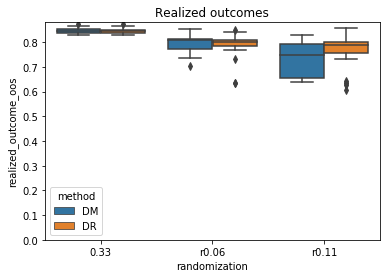

In [30]:
unconstrained = merged[merged['fairness'] == 1.0]

# plt.figure(figsize=(15, 5))
sns.boxplot(data=unconstrained, y='realized_outcome_oos', x='randomization', hue='method')
plt.title(f'Realized outcomes')
plt.ylim([0, 0.88])
plt.show()

#### b) Constrained

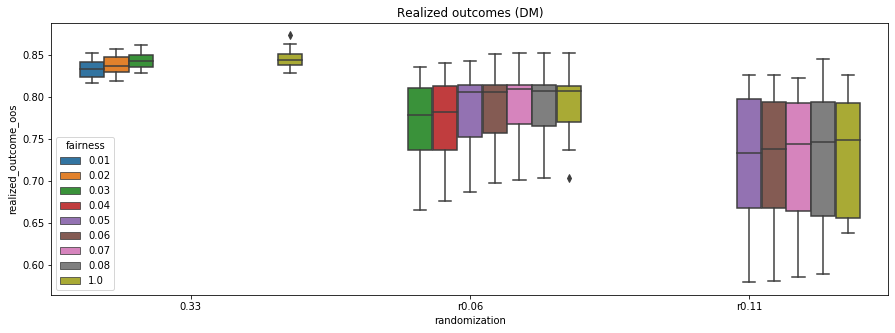

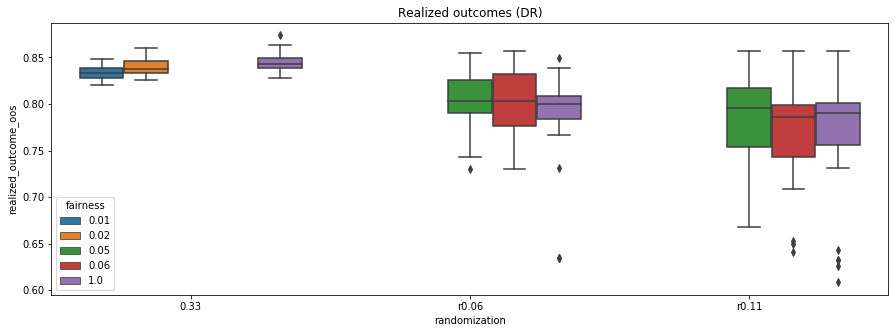

In [26]:
for m in ['DM', 'DR']:
    method = merged[merged['method'] == m]

    plt.figure(figsize=(15, 5))
    sns.boxplot(data=method, y='realized_outcome_oos', x='randomization', hue='fairness')
    plt.title(f'Realized outcomes ({m})')
    # plt.ylim([0, 0.88])
    plt.show()

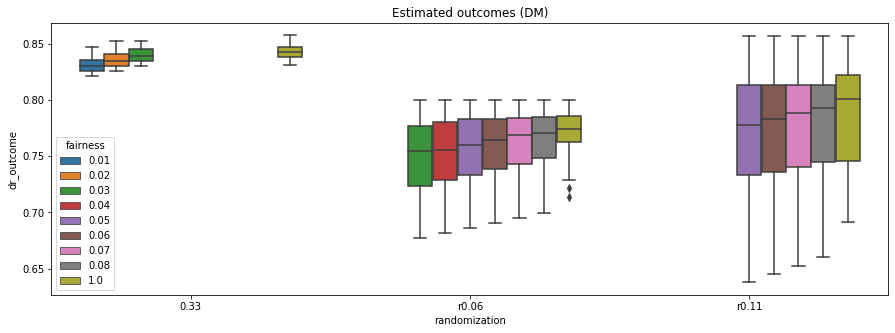

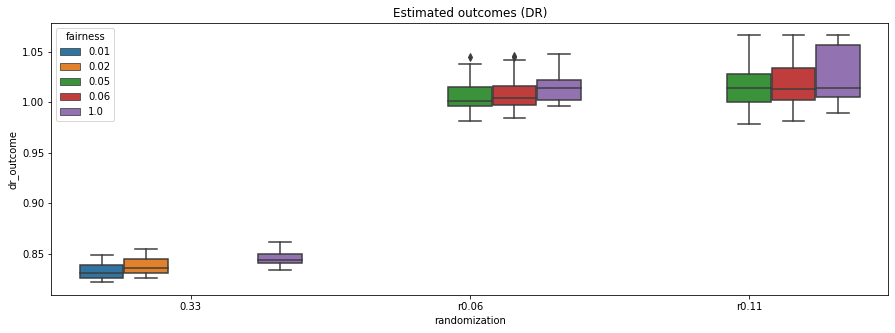

In [27]:
for m in ['DM', 'DR']:
    method = merged[merged['method'] == m]

    plt.figure(figsize=(15, 5))
    sns.boxplot(data=method, y='dr_outcome', x='randomization', hue='fairness')
    plt.title(f'Estimated outcomes ({m})')
    # plt.ylim([0, 0.88])
    plt.show()

### 2. Faithfulness of Expected Outcomes to Realized Outcomes

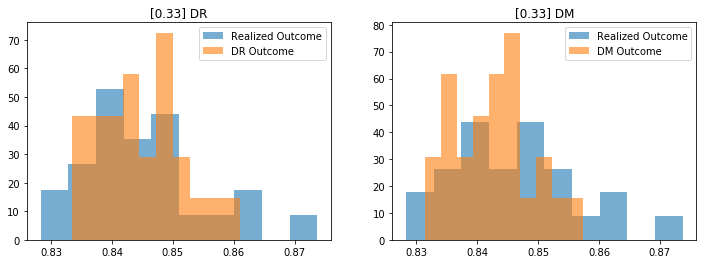

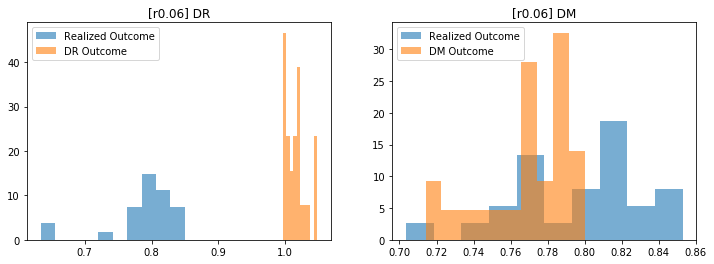

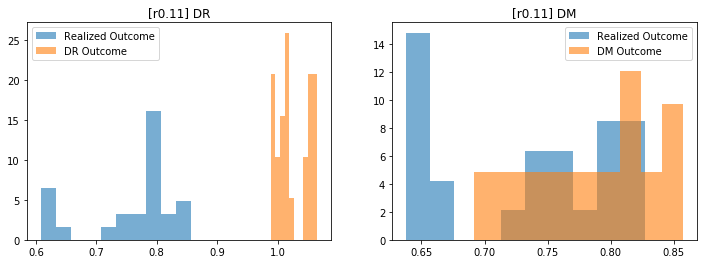

In [28]:
for r in ['0.33', 'r0.06', 'r0.11']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    subset = merged[(merged['randomization'] == r) & (merged['fairness'] == 1.0)]
    dr = subset[subset['method'] == 'DR']
    dm = subset[subset['method'] == 'DM']

    ax1.set_title(f'[{r}] DR')
    ax1.hist(dr['realized_outcome_oos'], label='Realized Outcome', alpha=0.6, density=True)
    ax1.hist(dr['dr_outcome'], label='DR Outcome', alpha=0.6, density=True)
    ax1.legend()
    
    ax2.set_title(f'[{r}] DM')
    ax2.hist(dm['realized_outcome_oos'], label='Realized Outcome', alpha=0.6, density=True)
    ax2.hist(dm['dr_outcome'], label='DM Outcome', alpha=0.6, density=True)
    ax2.legend()
    
    plt.show()

### 3. Fairness Constraints on Estimated vs. True Disparity
#### a) Doubly Robust Estimator

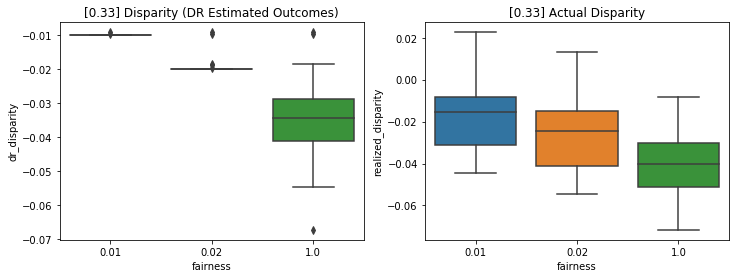

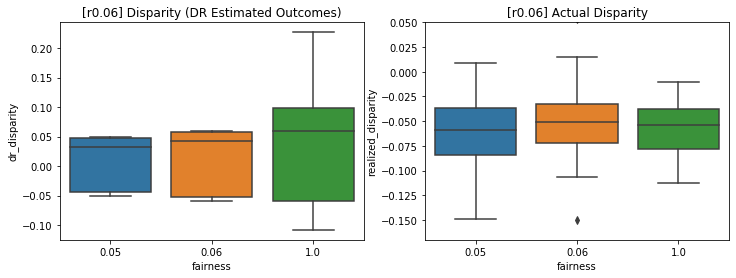

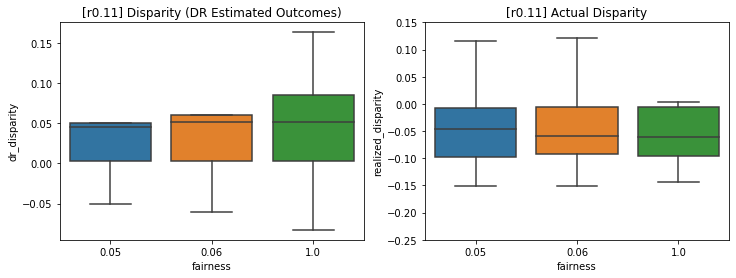

In [29]:
for r in ['0.33', 'r0.06', 'r0.11']:
    
    subset = merged[(merged['randomization'] == r) & (merged['method'] == 'DR')]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(data=subset, y='dr_disparity', x='fairness', ax=ax1)
    ax1.set_title(f'[{r}] Disparity (DR Estimated Outcomes)')
    
    sns.boxplot(data=subset, y='realized_disparity', x='fairness', ax=ax2)
    ax2.set_title(f'[{r}] Actual Disparity')
    if r == 'r0.11':
        ax2.set_ylim([-0.25, 0.15])
    elif r == 'r0.06':
        ax2.set_ylim([-0.17, 0.05])
    # plt.ylim([-0.05, 0.05])
    plt.show()

#### b) Direct Method Estimator

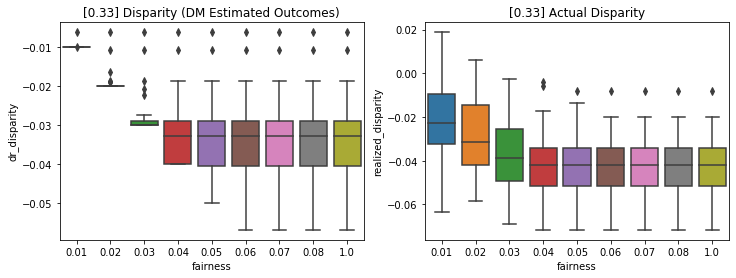

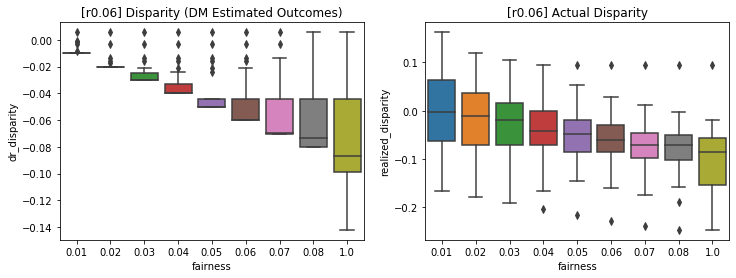

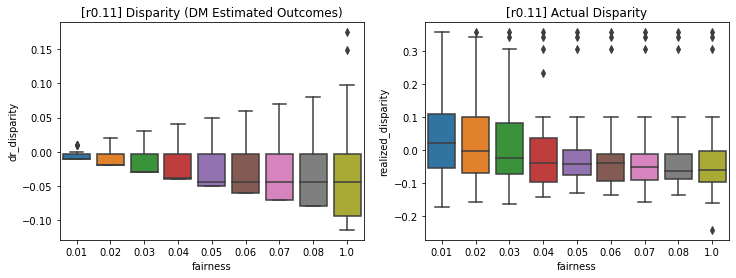

In [46]:
for r in ['0.33', 'r0.06', 'r0.11']:
    subset = warfarin_outcome[warfarin_outcome['randomization'] == r]
#     subset = merged[(merged['randomization'] == r) & (merged['method'] == 'DM')]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(data=subset, y='dr_disparity', x='fairness', ax=ax1)
    ax1.set_title(f'[{r}] Disparity (DM Estimated Outcomes)')
    
    sns.boxplot(data=subset, y='realized_disparity', x='fairness', ax=ax2)
    ax2.set_title(f'[{r}] Actual Disparity')
#     if r == 'r0.11':
#         ax2.set_ylim([-0.2, 0.12])
    plt.show()

In [54]:
r11 = warfarin_outcome[warfarin_outcome['randomization'] == 'r0.11']
not_r11 = warfarin_outcome[warfarin_outcome['randomization'] != 'r0.11']

In [55]:
def transform_white(row):
    if row['realized_disparity'] > 0:
        return row['white_realized_outcome_oos']
    else:
        if row['fairness'] <= 0.07 and row['fairness'] >= 0.03:
            return row['white_realized_outcome_oos'] + 0.0075
        else:
            return row['white_realized_outcome_oos']

In [56]:
def transform_nonwhite(row):
    if row['realized_disparity'] > 0:
        return row['non_white_realized_outcome_oos']
    else:
        if row['fairness'] <= 0.07 and row['fairness'] >= 0.03:
            return row['non_white_realized_outcome_oos'] - 0.0075
        else:
            return row['non_white_realized_outcome_oos']

In [57]:
r11['white_realized_outcome_oos'] = r11.apply(lambda row: transform_white(row), axis=1)
r11['non_white_realized_outcome_oos'] = r11.apply(lambda row: transform_nonwhite(row), axis=1)

In [58]:
r11['realized_disparity'] = r11['white_realized_outcome_oos']-r11['non_white_realized_outcome_oos']

In [59]:
combined = pd.concat([not_r11, r11], ignore_index=True)

In [61]:
combined.to_csv('compiled_results/DM.csv', index=False)

## IPW INVESTIGATION

In [95]:
seeds = range(1, 6)
splits = range(1, 6)
randomizations = ['0.33', 'r0.06', 'r0.11']
bounds = [1.0]

In [70]:
method = 'IPW'

In [71]:
sensitive_group = 'White'

warfarin_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'white_realized_outcome_oos', 'non_white_realized_outcome_oos', 
                                         'realized_outcome_oos', 'white_dr_outcome', 'non_white_dr_outcome', 'dr_outcome', 'tree_depth', 'tree', 'fairness', 'method'])
missing = []

for r in randomizations:
    for seed in seeds:
        for split in splits:
            fp_data = f'../data/Warfarin_v2/rf_balance_proba_white/seed{seed}'
            df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
            df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

            df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
            df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))

#             df_test['White'] = df_test.apply(lambda row: 1 if row['Asian'] == 0 and row['Black.or.African.American'] == 0 \
#                                             and row['Unknown.Race'] == 0 else 0, axis=1)
            
            for bound in bounds:
                tree = {}
                d=2
                fp = f'IPW/fairness/seed{seed}/Warfarin_seed{seed}_data_train_enc_{r}_{split}_IPW_d_{d}_t_3600_branching_limit_100.0_pred_tree_White_{bound}.p'

                if os.path.exists(fp):
                    with open(fp, 'rb') as f:
                        tree[d] = pickle.load(f)
                else:
                    missing.append(fp)
                    continue
                        

                df_test['y_d2'] = df_test.apply(lambda row: split_d2_prob(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
                df_train['t_d2'] = df_train.apply(lambda row: assign_d2_prob(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
#                 df_train['nu_ki'] = df_train.apply(lambda row: row[f"{ml}{int(row['t'])}"], axis=1)
                
                for d in [2]:
                    df_train['same_t_buffer'] = df_train.apply(lambda row: row[f't_d{d}'][int(row['t'])], axis=1)
                    df_train[f'dr_d{d}'] = df_train['y'] * ((df_train['same_t_buffer'])/df_train['prob_t_pred_tree'])

                    white_realized_outcome, non_white_realized_outcome = evaluate_disparity(df_test, sensitive_group, f'y_d{d}')
                    white_dr_outcome, non_white_dr_outcome = evaluate_disparity(df_train, sensitive_group, f'dr_d{d}')

                    realized_outcome = df_test['y_d2'].mean()
                    dr_outcome = df_train['dr_d2'].mean()
#                     print([seed, split, r, white_realized_outcome, non_white_realized_outcome, 
#                                                                    realized_outcome, white_dr_outcome, non_white_dr_outcome, dr_outcome, d, tree[d], bound, method])
                    warfarin_outcome.loc[len(warfarin_outcome)] = [seed, split, r, white_realized_outcome, non_white_realized_outcome, 
                                                                   realized_outcome, white_dr_outcome, non_white_dr_outcome, dr_outcome, d, tree[d], bound, method]

In [73]:
warfarin_outcome.to_csv('compiled_results/IPW.csv', index=False)

## KPT and BPT

In [84]:
sensitive_group = 'White'

warfarin_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'realized_outcome_oos', 'tree_depth', 'tree', 'method'])

method = 'Kallus'

for r in randomizations:
    for seed in seeds:
        for split in splits:
            fp_data = f'../data/Warfarin_v2/rf_balance_proba_white/seed{seed}'
            df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
            df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

            df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
            df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))

#             df_test['White'] = df_test.apply(lambda row: 1 if row['Asian'] == 0 and row['Black.or.African.American'] == 0 \
#                                             and row['Unknown.Race'] == 0 else 0, axis=1)
                
            tree = {}
            # UNCONSTRAINED
            for d in [2]:
#                 fp = f'Robust/seed{seed}/data_train_enc_{r}_{split}_Robust_d_{d}_t_3600_branching_limit_100.0_pred_tree.txt'
                fp = f'{method}/seed{seed}/data_train_enc_{r}_{split}_{method}_d_{d}_t_14400_branching_limit_100.0.txt'
                with open(fp) as f:
                    lines = [line.rstrip() for line in f]

                ids = []
                for idx, line in enumerate(lines):
                    if '#########' in line:
                        ids.append(idx)

                # create tree structure
                branching = []
                leaves = []
                if d == 1:
                    assert len(ids) == 3

                    branching.append(lines[ids[0]+1])
                    leaves.append(lines[ids[1]+1][-1])
                    leaves.append(lines[ids[2]+1][-1])

                elif d == 2:
                    assert len(ids) == 7
                    for i in range(3):
                        branching.append(lines[ids[i]+1])
                    for i in range(3, 7):
                        leaves.append(lines[ids[i]+1][-1])

                elif d == 3:
                    assert len(ids) == 15
                    branching = []
                    leaves = []
                    for i in range(7):
                        entry = lines[ids[i] + 1]
                        if 'leaf' in entry:
                            branching.append(f'pruned{entry[-1]}')
                        else:
                            branching.append(entry)

                    for i in range(7, 15):
                        entry = lines[ids[i]+1]
                        if 'pruned' in entry:
                            leaves.append('pruned')
                        else:
                            leaves.append(entry[-1])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

                tree[d] = {'branching': branching, 'leaves': leaves}
            
            df_test['y_d2'] = df_test.apply(lambda row: split_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
            df_train['t_d2'] = df_train.apply(lambda row: assign_d2(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
            
            realized_outcome = df_test['y_d2'].mean()
            warfarin_outcome.loc[len(warfarin_outcome)] = [seed, split, r, realized_outcome, d, tree[d], method]

In [85]:
warfarin_outcome.to_csv(f'compiled_results/{method}.csv', index=False)

KPT gap

In [128]:
cols = ['method', 'dataset', 'n', 'depth', 'branching', 'time_limit', 'status_code',
       'obj_value', 'gap', 'time_elapsed', 'regret_train', 'oosp_train', '?', 'regret_test', 'oosp_test', '?1']
df = pd.DataFrame(columns=cols)
for seed in [1, 2, 3, 4, 5]:
    for i in glob.glob(f'Bertsimas/seed{seed}/*'):
        if 'csv' in i:
            df_buffer = pd.read_csv(i, names=cols)
            df = pd.concat([df, df_buffer], ignore_index=True)


In [131]:
df['status_code'].value_counts()

9    74
2     1
Name: status_code, dtype: int64

In [122]:
cols = ['method', 'dataset', 'n', 'depth', 'branching', 'time_limit', 'status_code',
       'obj_value', 'gap', 'time_elapsed', 'regret_train', 'oosp_train', '?', 'regret_test', 'oosp_test', '?1']
df = pd.DataFrame(columns=cols)
for seed in [1, 2, 3, 4, 5]:
    for i in glob.glob(f'Kallus/seed{seed}/*'):
        if 'csv' in i:
            df_buffer = pd.read_csv(i, names=cols)
            df = pd.concat([df, df_buffer], ignore_index=True)


In [125]:
df[df['gap'] > 0]

,method,dataset,n,depth,branching,time_limit,status_code,obj_value,gap,time_elapsed,regret_train,oosp_train,?,regret_test,oosp_test,?1
18,Kallus,data_train_enc_r0.11_4,3000,2,100.0,14400,2,2958.187512,0.009886,10666.762361,1847,38.433333,33.300000,859,38.023088,32.828283
24,Kallus,data_train_enc_r0.11_2,3000,2,100.0,14400,9,2953.724138,0.292730,14411.449953,1967,34.433333,28.533333,921,33.549784,29.004329


In [116]:
df['status_code'].value_counts()

2    74
9     1
Name: status_code, dtype: int64

In [118]:
df['gap'].value_counts()

0.000000    73
0.292730     1
0.009886     1
Name: gap, dtype: int64

In [27]:
r=0.33
split = 2
fp_data = f'../data/Warfarin_v2/rf_balance_proba_white/seed1'
df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

In [59]:
res = pd.read_csv('Robust/delete_later/data_train_enc_0.33_2_Robust_d_2_t_10800_branching_limit_100.0_pred_tree_White_0.02.csv')

In [42]:
import pickle
with open('Robust/delete_later/data_train_enc_0.33_1_Robust_d_2_t_10800_branching_limit_100.0_pred_tree_White_0.02.p', 'rb') as f:
    zeta = pickle.load(f)

In [28]:
import pickle
with open('Robust/delete_later/data_train_enc_0.33_2_Robust_d_2_t_10800_branching_limit_100.0_pred_tree_White_0.02.p', 'rb') as f:
    zeta = pickle.load(f)

protected_col = 'White'
outcome = 'y'
prob_t = 'prob_t_pred_tree'
treatments_set = [0, 1, 2]
regression = ['ml0', 'ml1', 'ml2']
treatment_col = 't'
protected_df = df_train[df_train[protected_col] == 0]
protected_prime_df = df_train[df_train[protected_col] == 1]

nonwhite = 1/len(protected_df) * (np.sum([zeta[(i, n, k)]*(protected_df.at[i, outcome] - protected_df.at[i, regression[int(k)]])/protected_df.at[i, prob_t] for i in protected_df.index for n in range(1, 8) for k in treatments_set if protected_df.at[i, treatment_col] == int(k)]) + \
    np.sum([zeta[(i, n, k)]*(protected_df.at[i, regression[int(k)]]) for i in protected_df.index for n in range(1, 8) for k in treatments_set]))
white =  1/len(protected_prime_df) * (np.sum([zeta[(i, n, k)]*(protected_prime_df.at[i, outcome] - protected_prime_df.at[i, regression[int(k)]])/protected_prime_df.at[i, prob_t] for i in protected_prime_df.index for n in range(1, 8) for k in treatments_set if protected_prime_df.at[i, treatment_col] == int(k)]) + \
    np.sum([zeta[(i, n, k)]*(protected_prime_df.at[i, regression[int(k)]]) for i in protected_prime_df.index for n in range(1, 8) for k in treatments_set]))

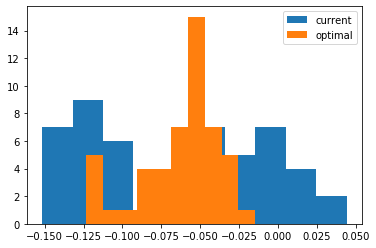

In [235]:
# ARCHIVED FOR INVESTIGATION
plt.hist(warfarin_outcome[(warfarin_outcome['randomization'] != '0.33') & (warfarin_outcome['fairness'] == 1.0)]['dr_disparity'], label='current')
plt.hist(optimal_split[(optimal_split['randomization'] != '0.33') & (optimal_split['fairness'] == 1.0)]['dr_disparity'], label='optimal')
plt.legend()
plt.show()


# Synthetic Data

In [180]:
cols = ['method', 'data', 'n_train', 'depth', 'branching_limit', 'time_limit', 'solve_status', 'obj_value', 'gap', 
        'solve_time', 'regret_train', 'best_found_train', 'acc_train', 'regret_test', 'best_found_test', 'acc_test', 
        'prob_type_pred', 'ml', 'budget_constraint']
synthetic_df = pd.read_csv('../Results/HPC Results/Robust_Athey_v1_500.csv', names=cols[:-1])
synthetic_budget_df = pd.read_csv('../Results_Atheyv1/Robust/athey_v1_budget.csv', names=cols)
synthetic_df['r'] = synthetic_df['data'].apply(lambda x: float(x.split('_')[-2]))
synthetic_budget_df['r'] = synthetic_budget_df['data'].apply(lambda x: float(x.split('_')[-2]))

In [55]:
synthetic_df = synthetic_df[(synthetic_df['depth'].isin([1, 2])) & (synthetic_df['prob_type_pred'] == 'tree') \
                            & (synthetic_df['ml'] == 'linear')]

In [56]:
synthetic_budget_df = synthetic_budget_df[(synthetic_budget_df['depth'].isin([1, 2])) \
                                          & (synthetic_budget_df['prob_type_pred'] == 'tree') \
                            & (synthetic_budget_df['ml'] == 'linear')]

In [57]:
synthetic_df['budget'] = 'no budget'
synthetic_budget_df['budget'] = '0.2'

In [166]:
synthetic_df = synthetic_df[(synthetic_df['depth'] == 1) & (synthetic_df['prob_type_pred'] == 'tree') \
                            & (synthetic_df['ml'] == 'linear')]

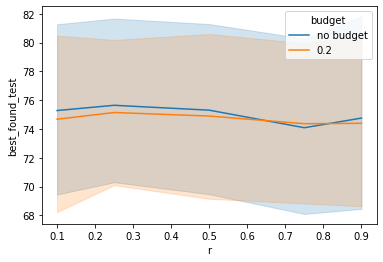

In [58]:
sns.lineplot(data=pd.concat([synthetic_df, synthetic_budget_df]), y='best_found_test', x='r', hue="budget")
plt.show()

In [61]:
r = 0.5
split = 1

DR

In [136]:
randomization = [0.1, 0.25, 0.5, 0.75, 0.9]
splits = [1, 2, 3, 4, 5]
budgets = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21,
                0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36,
                0.37, 0.38, 0.39, 0.4, 1.0]
missing = []
results_synthetic = pd.DataFrame(columns=['split', 'randomization', 'budget', 'tree_depth', 'propensity_score_pred',
                                          'ml', 'oos_regret', 'oos_optimal_treatment', 'oos_avg_outcome', 'tree'])
for r in randomization:
    for split in splits:
        fp_data = f'../data/Athey_v1/500/'
        df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
        df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

        df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
        df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))
        
        # calculate optional treatment and outcome
        df_test['opt_t'] = df_test.apply(lambda row: 0 if row['y0'] > row['y1'] else 1, axis=1)
        df_test['opt_y'] = df_test.apply(lambda row: row['y0'] if row['y0'] > row['y1'] else row['y1'], axis=1)
        
        # loop through types of ML and preds
        for budget in budgets:
            results_fp = f'../Results_Atheyv1/Robust/'
            for pred in ['tree', 'log']:
                for ml in ['linear', 'lasso']:
                    tree = {}
                    d = 1
                    fn = f'data_train_enc_{r}_{split}_Robust_d_{d}_t_3600_branching_limit_100.0_pred_{pred}_ml_{ml}_budget_{budget}.p'
#                         # THIS IS TEMPORARY BECAUSE .p didn't exist
                    if not os.path.exists(os.path.join(results_fp, fn)):
                        missing.append(fn)
                        continue

                    with open(os.path.join(results_fp, fn), 'rb') as f:
                        tree[d] = pickle.load(f)


                    df_test['y_d1'] = df_test.apply(lambda row: split_d1_prob(row, tree[1]['branching'], 
                                                                        tree[1]['leaves']), axis=1)
                    df_test['t_d1'] = df_test.apply(lambda row: assign_d1_prob(row, tree[1]['branching'], 
                                                                        tree[1]['leaves']), axis=1)

                    df_test['regret'] = df_test['opt_y']-df_test[f'y_d{d}']
                    optimal_treatment_perc = (df_test['t_d1'] == df_test['opt_t']).sum()/len(df_test)
                    avg_outcome = df_test[f'y_d{d}'].mean()

                    results_synthetic.loc[len(results_synthetic)] = [split, r, budget, d, pred, ml, df_test['regret'].sum(),
                                                                    optimal_treatment_perc, avg_outcome, tree[d]]

In [137]:
missing

['data_train_enc_0.1_4_Robust_d_1_t_3600_branching_limit_100.0_pred_log_ml_lasso_budget_0.05.p',
 'data_train_enc_0.25_2_Robust_d_1_t_3600_branching_limit_100.0_pred_tree_ml_linear_budget_0.06.p',
 'data_train_enc_0.25_2_Robust_d_1_t_3600_branching_limit_100.0_pred_tree_ml_lasso_budget_0.06.p',
 'data_train_enc_0.25_2_Robust_d_1_t_3600_branching_limit_100.0_pred_log_ml_linear_budget_0.06.p',
 'data_train_enc_0.5_2_Robust_d_1_t_3600_branching_limit_100.0_pred_log_ml_linear_budget_0.06.p',
 'data_train_enc_0.5_2_Robust_d_1_t_3600_branching_limit_100.0_pred_log_ml_lasso_budget_0.06.p',
 'data_train_enc_0.75_2_Robust_d_1_t_3600_branching_limit_100.0_pred_tree_ml_linear_budget_0.06.p',
 'data_train_enc_0.75_2_Robust_d_1_t_3600_branching_limit_100.0_pred_log_ml_lasso_budget_0.11.p',
 'data_train_enc_0.9_2_Robust_d_1_t_3600_branching_limit_100.0_pred_tree_ml_linear_budget_0.06.p',
 'data_train_enc_0.9_2_Robust_d_1_t_3600_branching_limit_100.0_pred_log_ml_linear_budget_0.06.p']

In [138]:
results_synthetic

,split,randomization,budget,tree_depth,propensity_score_pred,ml,oos_regret,oos_optimal_treatment,oos_avg_outcome,tree
0,1,0.1,0.05,1,tree,linear,143.970523,0.6103,0.481399,"{'branching': ['V1.9'], 'leaves': [{0: 0.51923..."
1,1,0.1,0.05,1,tree,lasso,165.319473,0.5851,0.479264,"{'branching': ['V2.1'], 'leaves': [{0: 1.0, 1:..."
2,1,0.1,0.05,1,log,linear,143.970523,0.6106,0.481399,"{'branching': ['V1.9'], 'leaves': [{0: 0.51923..."
3,1,0.1,0.05,1,log,lasso,143.970523,0.6113,0.481399,"{'branching': ['V1.9'], 'leaves': [{0: 0.51923..."
4,1,0.1,0.06,1,tree,linear,136.841760,0.6208,0.482112,"{'branching': ['V1.9'], 'leaves': [{0: 0.42307..."
...,...,...,...,...,...,...,...,...,...,...
3685,5,0.9,0.40,1,log,lasso,128.735336,0.6567,0.499324,"{'branching': ['V1.3'], 'leaves': [{0: 1.0, 1:..."
3686,5,0.9,1.00,1,tree,linear,26.756559,0.8475,0.509521,"{'branching': ['V1.6'], 'leaves': [{0: 0.0, 1:..."
3687,5,0.9,1.00,1,tree,lasso,41.932747,0.8023,0.508004,"{'branching': ['V1.5'], 'leaves': [{0: 0.0, 1:..."
3688,5,0.9,1.00,1,log,linear,224.601316,0.5329,0.489737,"{'branching': ['V2.8'], 'leaves': [{0: 0.0, 1:..."


In [139]:
results_synthetic.to_csv('../Results_Atheyv1/compiled_results/DR.csv', index=False)

DM

In [101]:
randomization = [0.1, 0.25, 0.5, 0.75, 0.9]
splits = [1, 2, 3, 4, 5]
budgets = [1.0]

results_synthetic = pd.DataFrame(columns=['split', 'randomization', 'budget', 'tree_depth', 'propensity_score_pred',
                                          'ml', 'oos_regret', 'oos_optimal_treatment', 'oos_avg_outcome', 'tree'])
for r in randomization:
    for split in splits:
        fp_data = f'../data/Athey_v1/500/'
        df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
        df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

        df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
        df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))
        
        # calculate optional treatment and outcome
        df_test['opt_t'] = df_test.apply(lambda row: 0 if row['y0'] > row['y1'] else 1, axis=1)
        df_test['opt_y'] = df_test.apply(lambda row: row['y0'] if row['y0'] > row['y1'] else row['y1'], axis=1)
        
        # loop through types of ML and preds
        for budget in budgets:
            results_fp = f'../Results_Atheyv1/DM/'
            for pred in ['tree']:
                for ml in ['linear', 'lasso']:
                    tree = {}
                    for d in [1]:
                        fn = f'data_train_enc_{r}_{split}_Direct_d_{d}_t_3600_branching_limit_100.0_pred_{pred}_ml_{ml}_budget_{budget}.p'
                        
                        with open(os.path.join(results_fp, fn), 'rb') as f:
                            tree[d] = pickle.load(f)


                        df_test['y_d1'] = df_test.apply(lambda row: split_d1_prob(row, tree[1]['branching'], 
                                                                            tree[1]['leaves']), axis=1)
                        df_test['t_d1'] = df_test.apply(lambda row: assign_d1_prob(row, tree[1]['branching'], 
                                                                            tree[1]['leaves']), axis=1)

                    for d in [1]:
                        df_test['regret'] = df_test['opt_y']-df_test[f'y_d{d}']
                        optimal_treatment_perc = (df_test['t_d1'] == df_test['opt_t']).sum()/len(df_test)
                        avg_outcome = df_test[f'y_d{d}'].mean()

                        results_synthetic.loc[len(results_synthetic)] = [split, r, budget, d, pred, ml, df_test['regret'].sum(),
                                                                        optimal_treatment_perc, avg_outcome, tree[d]]

In [102]:
results_synthetic.to_csv('../Results_Atheyv1/compiled_results/DM.csv', index=False)

IPW

In [94]:
tree[1]

{'branching': [{0: 1.0, 1: 0.0}], 'leaves': ['pruned', 'pruned']}

In [103]:
randomization = [0.1, 0.25, 0.5, 0.75, 0.9]
splits = [1, 2, 3, 4, 5]

results_synthetic = pd.DataFrame(columns=['split', 'randomization', 'tree_depth', 'propensity_score_pred',
                                          'oos_regret', 'oos_optimal_treatment', 'oos_avg_outcome', 'tree'])
for r in randomization:
    for split in splits:
        fp_data = f'../data/Athey_v1/500/'
        df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
        df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

        df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
        df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))
        
        # calculate optional treatment and outcome
        df_test['opt_t'] = df_test.apply(lambda row: 0 if row['y0'] > row['y1'] else 1, axis=1)
        df_test['opt_y'] = df_test.apply(lambda row: row['y0'] if row['y0'] > row['y1'] else row['y1'], axis=1)
        
        # loop through types of ML and preds
        results_fp = f'../Results_Atheyv1/IPW/'
        for pred in ['tree', 'log']:
            tree = {}
            for d in [1]:
                fn = f'Athey_v1_500_data_train_enc_{r}_{split}_IPW_d_{d}_t_3600_branching_limit_100.0_pred_{pred}.p'

                with open(os.path.join(results_fp, fn), 'rb') as f:
                    tree[d] = pickle.load(f)


                df_test['y_d1'] = df_test.apply(lambda row: split_d1_prob(row, tree[1]['branching'], 
                                                                    tree[1]['leaves']), axis=1)
                df_test['t_d1'] = df_test.apply(lambda row: assign_d1_prob(row, tree[1]['branching'], 
                                                                    tree[1]['leaves']), axis=1)

            for d in [1]:
                df_test['regret'] = df_test['opt_y']-df_test[f'y_d{d}']
                optimal_treatment_perc = (df_test['t_d1'] == df_test['opt_t']).sum()/len(df_test)
                avg_outcome = df_test[f'y_d{d}'].mean()

                results_synthetic.loc[len(results_synthetic)] = [split, r, d, pred, df_test['regret'].sum(),
                                                                optimal_treatment_perc, avg_outcome, tree[d]]

In [104]:
results_synthetic.to_csv('../Results_Atheyv1/compiled_results/IPW.csv', index=False)

KPT/BPT

In [110]:
randomization = [0.1, 0.25, 0.5, 0.75, 0.9]
splits = [1, 2, 3, 4, 5]
method = 'Bertsimas'

results_synthetic = pd.DataFrame(columns=['split', 'randomization', 'tree_depth',
                                          'oos_regret', 'oos_optimal_treatment', 'oos_avg_outcome', 'tree'])
for r in randomization:
    for split in splits:
        fp_data = f'../data/Athey_v1/500/'
        df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
        df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

        df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
        df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))
        
        # calculate optional treatment and outcome
        df_test['opt_t'] = df_test.apply(lambda row: 0 if row['y0'] > row['y1'] else 1, axis=1)
        df_test['opt_y'] = df_test.apply(lambda row: row['y0'] if row['y0'] > row['y1'] else row['y1'], axis=1)
    
        
        for d in [1]:
            fp = f'../Results_Atheyv1/{method}/data_train_enc_{r}_{split}_{method}_d_{d}_t_10800_branching_limit_100.0.txt'
            with open(fp) as f:
                lines = [line.rstrip() for line in f]

            ids = []
            for idx, line in enumerate(lines):
                if '#########' in line:
                    ids.append(idx)

            # create tree structure
            branching = []
            leaves = []
            if d == 1:
                assert len(ids) == 3

                branching.append(lines[ids[0]+1])
                leaves.append(lines[ids[1]+1][-1])
                leaves.append(lines[ids[2]+1][-1])

            elif d == 2:
                assert len(ids) == 7
                for i in range(3):
                    branching.append(lines[ids[i]+1])
                for i in range(3, 7):
                    leaves.append(lines[ids[i]+1][-1])

            elif d == 3:
                assert len(ids) == 15
                branching = []
                leaves = []
                for i in range(7):
                    entry = lines[ids[i] + 1]
                    if 'leaf' in entry:
                        branching.append(f'pruned{entry[-1]}')
                    else:
                        branching.append(entry)

                for i in range(7, 15):
                    entry = lines[ids[i]+1]
                    if 'pruned' in entry:
                        leaves.append('pruned')
                    else:
                        leaves.append(entry[-1])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

            tree[d] = {'branching': branching, 'leaves': leaves}
            
        df_test['y_d1'] = df_test.apply(lambda row: split_d1(row, tree[1]['branching'], 
                                                                    tree[1]['leaves']), axis=1)
        df_test['t_d1'] = df_test.apply(lambda row: assign_d1(row, tree[1]['branching'], 
                                                            tree[1]['leaves']), axis=1)
        d=1
        df_test['regret'] = df_test['opt_y']-df_test[f'y_d{d}']
        optimal_treatment_perc = (df_test['t_d1'] == df_test['opt_t']).sum()/len(df_test)
        avg_outcome = df_test[f'y_d{d}'].mean()
        
        results_synthetic.loc[len(results_synthetic)] = [split, r, d, df_test['regret'].sum(),
                                                                optimal_treatment_perc, avg_outcome, tree[d]]

In [111]:
results_synthetic.to_csv(f'../Results_Atheyv1/compiled_results/{method}.csv', index=False)

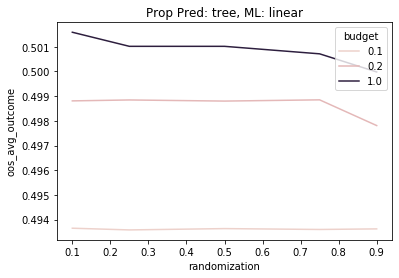

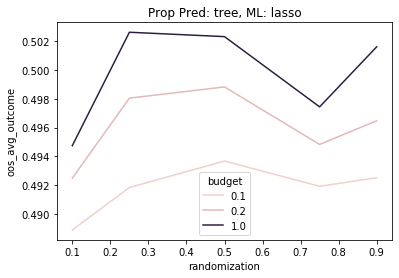

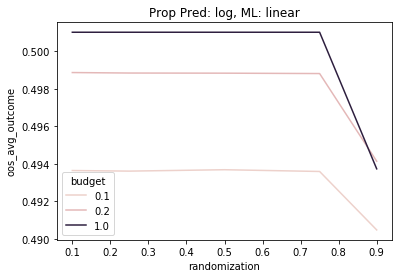

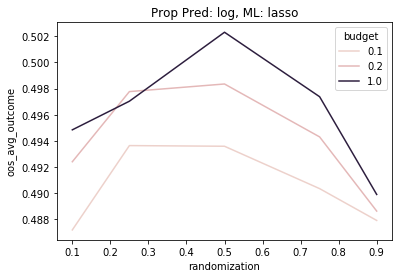

In [32]:
for pred in ['tree', 'log']:
    for ml in ['linear', 'lasso']:
        sub = results_synthetic[(results_synthetic['propensity_score_pred'] == pred) & \
                                    (results_synthetic['ml'] == ml)][['budget', 'randomization', 
                                                'oos_avg_outcome']].groupby(['budget', 'randomization']).agg('mean').reset_index()
        sns.lineplot(data=sub, 
             y='oos_avg_outcome', x='randomization', hue='budget')
        plt.title(f'Prop Pred: {pred}, ML: {ml}')
        plt.show()

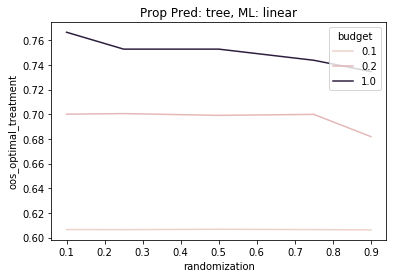

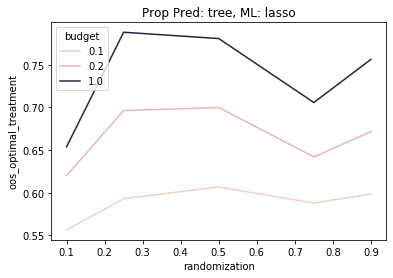

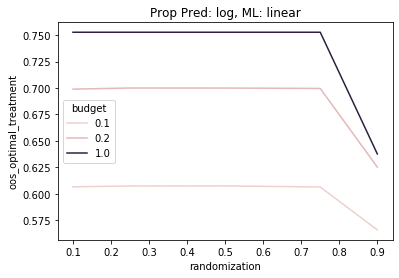

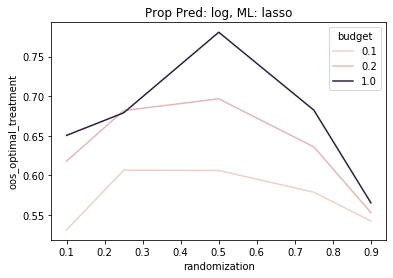

In [29]:
for pred in ['tree', 'log']:
    for ml in ['linear', 'lasso']:
        sub = results_synthetic[(results_synthetic['propensity_score_pred'] == pred) & \
                                    (results_synthetic['ml'] == ml)][['budget', 'randomization', 
                                                'oos_optimal_treatment']].groupby(['budget', 'randomization']).agg('mean').reset_index()
        sns.lineplot(data=sub, 
             y='oos_optimal_treatment', x='randomization', hue='budget')
        plt.title(f'Prop Pred: {pred}, ML: {ml}')
        plt.show()

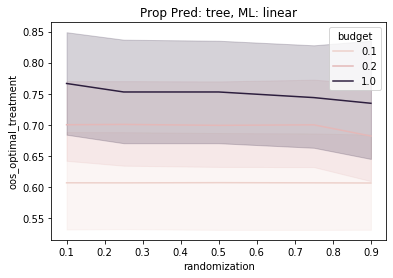

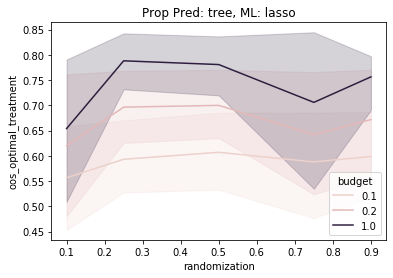

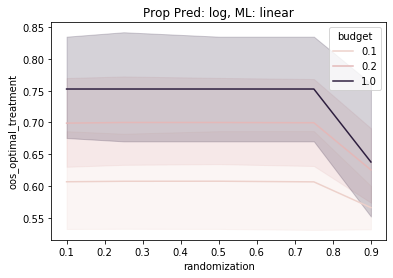

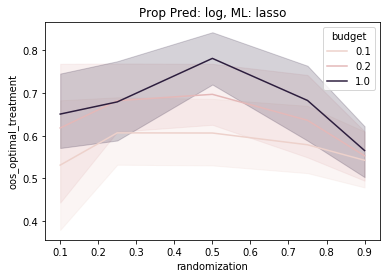

In [21]:
for pred in ['tree', 'log']:
    for ml in ['linear', 'lasso']:
        sub = results_synthetic[(results_synthetic['propensity_score_pred'] == pred) & \
                                    (results_synthetic['ml'] == ml)][['budget', 'randomization', 
                                                'oos_optimal_treatment']].groupby(['budget', 'randomization']).agg('mean')
        sns.lineplot(data=results_synthetic[(results_synthetic['propensity_score_pred'] == pred) & \
                                    (results_synthetic['ml'] == ml)], 
             y='oos_optimal_treatment', x='randomization', hue='budget')
        plt.title(f'Prop Pred: {pred}, ML: {ml}')
        plt.show()

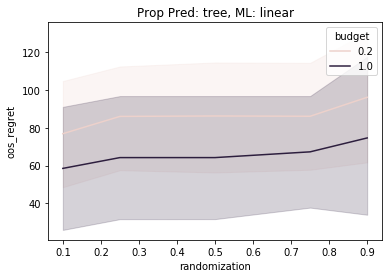

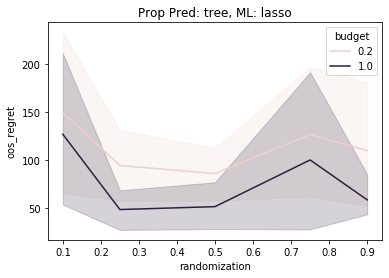

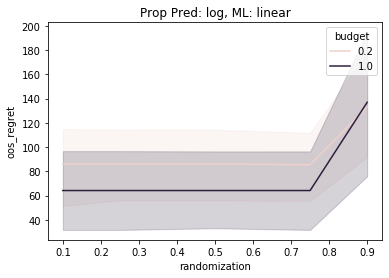

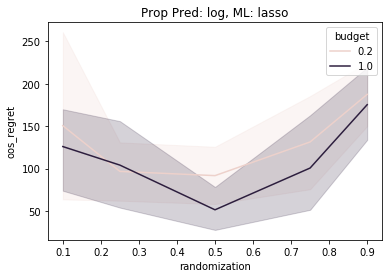

In [184]:
for pred in ['tree', 'log']:
    for ml in ['linear', 'lasso']:
        sns.lineplot(data=results_synthetic[(results_synthetic['propensity_score_pred'] == pred) & \
                                    (results_synthetic['ml'] == ml)], 
             y='oos_regret', x='randomization', hue='budget')
        plt.title(f'Prop Pred: {pred}, ML: {ml}')
        plt.show()

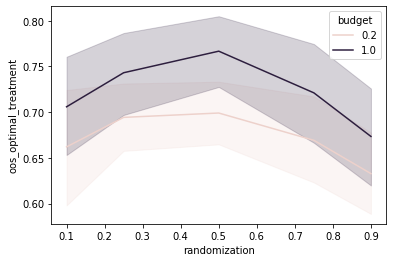

In [155]:
sns.lineplot(data=results_synthetic, y='oos_optimal_treatment', x='randomization', hue='budget')
plt.show()

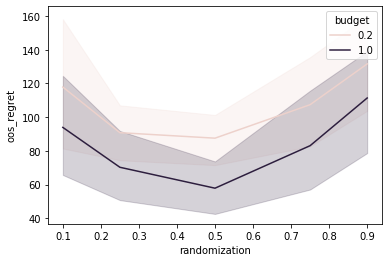

In [156]:
sns.lineplot(data=results_synthetic, y='oos_regret', x='randomization', hue='budget')
plt.show()

In [151]:
results_synthetic

,split,randomization,budget,tree_depth,propensity_score_pred,ml,oos_regret,oos_optimal_treatment,oos_avg_outcome,tree
0,1,0.1,0.2,1,tree,linear,64.409275,0.7471,0.489355,"{'branching': ['V1.8'], 'leaves': [{0: 0.01960..."
1,1,0.1,0.2,1,tree,lasso,84.741142,0.7313,0.487322,"{'branching': ['V1.7'], 'leaves': [{0: 0.31972..."
2,1,0.1,0.2,1,log,linear,63.249920,0.7477,0.489471,"{'branching': ['V1.8'], 'leaves': [{0: 0.01960..."
3,1,0.1,0.2,1,log,lasso,64.233225,0.7474,0.489373,"{'branching': ['V1.8'], 'leaves': [{0: 0.01960..."
4,1,0.1,1.0,1,tree,linear,46.272102,0.7849,0.491169,"{'branching': ['V1.4'], 'leaves': [{0: 1.11022..."
...,...,...,...,...,...,...,...,...,...,...
194,5,0.9,0.2,1,log,lasso,128.735336,0.6567,0.499324,"{'branching': ['V1.1'], 'leaves': [{0: 1.0, 1:..."
195,5,0.9,1.0,1,tree,linear,26.756559,0.8475,0.509521,"{'branching': ['V1.6'], 'leaves': [{0: 0.0, 1:..."
196,5,0.9,1.0,1,tree,lasso,41.932747,0.8023,0.508004,"{'branching': ['V1.5'], 'leaves': [{0: 0.0, 1:..."
197,5,0.9,1.0,1,log,linear,224.601316,0.5329,0.489737,"{'branching': ['V2.8'], 'leaves': [{0: 0.0, 1:..."


In [142]:
df_test.columns

Index(['V1.1', 'V1.2', 'V1.3', 'V1.4', 'V1.5', 'V1.6', 'V1.7', 'V1.8', 'V1.9',
       'V1.10', 'V2.1', 'V2.2', 'V2.3', 'V2.4', 'V2.5', 'V2.6', 'V2.7', 'V2.8',
       'V2.9', 'V2.10', 'y0', 'y1', 't', 'prob_t', 'y', 'prob_t_pred_log',
       'prob_t_pred_tree', 'opt_t', 'opt_y', 'y_d1', 't_d1', 'y_d2', 't_d2',
       'regret'],
      dtype='object')

In [ ]:
results_synthetic = results_synthetic[(results_synthetic['tree_depth'].isin([1, 2])) & (results_synthetic['propensity_score_pred'] == 'tree') \
                            & (results_synthetic['ml'] == 'linear')]

In [ ]:
sns.lineplot(data=results_synthetic, y='oos_regret', x='randomization', hue="budget")
plt.show()

Playground

In [64]:
fp_data = f'../data/Athey_v1/500/'
df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))

In [93]:
df_test['y_d1'] = df_test.apply(lambda row: split_d1(row, ['V1.8'], [1, 0]), axis=1)
df_test['t_d1'] = df_test.apply(lambda row: assign_d1(row, ['V1.8'], [1, 0]), axis=1)

In [94]:
df_test['opt_t'] = df_test.apply(lambda row: 0 if row['y0'] > row['y1'] else 1, axis=1)
df_test['opt_y'] = df_test.apply(lambda row: row['y0'] if row['y0'] > row['y1'] else row['y1'], axis=1)

In [95]:
df_test['regret'] = df_test['opt_y']-df_test['y_d1']

In [96]:
(df_test['t_d1'] == df_test['opt_t']).sum()/len(df_test)

0.751

In [97]:
df_test['regret'].sum()

61.81383226800064

In [98]:
df_test['y_d1'].mean()

0.4896147891093432

In [86]:
(df_test['t_d1'] == df_test['opt_t']).sum()/len(df_test)

0.8304

In [87]:
df_test['regret'].sum()

30.5457150353341

In [90]:
df_test['y_d1'].mean()

0.49274160083261015

In [75]:
df_test

,V1.1,V1.2,V1.3,V1.4,V1.5,V1.6,V1.7,V1.8,V1.9,V1.10,...,y0,y1,t,prob_t,y,prob_t_pred_log,prob_t_pred_tree,y_d1,t_d1,opt_t
0,0,0,1,1,1,1,1,1,1,1,...,0.473488,0.450195,0,0.5,0.473488,0.534665,0.534,0.473488,0,0
1,0,1,1,1,1,1,1,1,1,1,...,0.399489,0.347571,1,0.5,0.347571,0.471807,0.466,0.399489,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0.526518,0.576038,1,0.5,0.576038,0.461458,0.466,0.576038,1,1
3,0,0,0,0,0,0,0,1,1,1,...,0.338760,0.404628,0,0.5,0.338760,0.525321,0.534,0.404628,1,1
4,1,1,1,1,1,1,1,1,1,1,...,0.553160,0.420586,0,0.5,0.553160,0.536588,0.534,0.553160,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,1,1,1,1,1,1,1,1,...,0.669857,0.603873,0,0.5,0.669857,0.546268,0.534,0.669857,0,0
9996,0,0,0,0,1,1,1,1,1,1,...,0.608173,0.555163,0,0.5,0.608173,0.542559,0.534,0.608173,0,0
9997,0,0,0,0,0,0,0,0,1,1,...,0.475340,0.508981,1,0.5,0.508981,0.466873,0.466,0.508981,1,1
9998,0,0,0,0,0,0,0,1,1,1,...,0.630942,0.643760,0,0.5,0.630942,0.543437,0.534,0.643760,1,1
